# COVID-19 NIH DATA ANALYSIS

This is a simple Notebook that extracts the data https://github.com/CSSEGISandData/COVID-19 and uses Pandas, numpy and scipy to model the time series. I have played around with different fitting and optimization techniques but finally based on validation using Nelder-Mead and Emmanuelle Le Nagard and Alexandre Steyer on innovation diffusion. 

In [146]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [149]:
# Reading Data
data=pd.read_csv('./COVID-19/COVID-19/covid_19_data.csv' ,parse_dates=['Last Update'])
data.rename(columns={'ObservationDate':'Date', 'Country/Region':'Country'}, inplace=True)

# latest Cases
data.tail()

,SNo,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
6717,6718,03/18/2020,NaN,Guernsey,2020-03-17 18:33:03,0.0,0.0,0.0
6718,6719,03/18/2020,NaN,Jersey,2020-03-17 18:33:03,0.0,0.0,0.0
6719,6720,03/18/2020,NaN,Puerto Rico,2020-03-17 16:13:14,0.0,0.0,0.0
6720,6721,03/18/2020,NaN,Republic of the Congo,2020-03-17 21:33:03,0.0,0.0,0.0
6721,6722,03/18/2020,NaN,The Gambia,2020-03-18 14:13:56,0.0,0.0,0.0


In [150]:
country = "US"
query = "Country==\"" + country + "\""
print(query)

Country=="US"


In [151]:
# creating  a dataframe from query of the country
result = data.query(query).groupby("Date")[['Confirmed']].sum().reset_index()
df = result
# create an indeex 
df.set_index('Date')
# rename the column to have the country name
new_col = 'Confirmed ' + country
df= df.rename(columns={'Confirmed':new_col})
df.tail(10)

,Date,Confirmed US
47,03/09/2020,605.0
48,03/10/2020,959.0
49,03/11/2020,1281.0
50,03/12/2020,1663.0
51,03/13/2020,2179.0
52,03/14/2020,2726.0
53,03/15/2020,3499.0
54,03/16/2020,4632.0
55,03/17/2020,6421.0
56,03/18/2020,7786.0


In [157]:
# Emmanuelle Le Nagard and Alexandre Steyer on innovation diffusion
import math
def model(N, a, alpha, t):
    # we enforce N, a and alpha to be positive numbers using min and max functions
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [153]:
# calculate the loss of the model using squared error
def model_loss(params):
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, 1]) ** 2
    return r 

In [158]:
# optimization module
import numpy as np
from scipy.optimize import minimize
opt = minimize(model_loss, x0=np.array([200000, 0.1, 15]), method='Nelder-Mead', tol=1e-5).x
opt

array([4.45329350e+06, 3.35415917e-02, 3.82871501e+01])

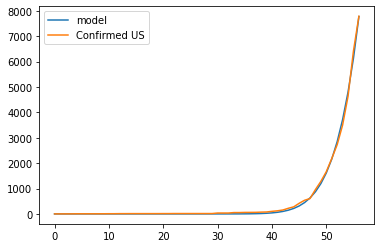

In [159]:
# use entire dataset to model
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['model']
pd.concat([model_sim, df], axis=1).plot()
plt.show()

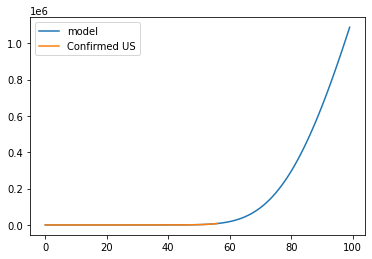

In [160]:
#predict for next 100 days
import datetime
start = df.index[0]
n_days = 100
extended_model_x = []
for t in range(n_days):
    extended_model_x.append([start+t, model(*opt, t)])
extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)
extended_model_sim.columns = ['model']
pd.concat([extended_model_sim, df], axis=1).plot()
plt.show()